# Lab: CV w/CNNs

# Part 1: Libraries & Preprocessing

### Step 1: Libraries

Bring in the germane libraries.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# TensorFlow / Keras functions
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

### Step 2: Data

Download and fetch the data with the following Python code (Note: We will use faces.images for X.)

In [8]:
from scipy.io import loadmat
from types import SimpleNamespace

mat = loadmat("olivettifaces.mat")
images = mat["faces"].T.reshape(-1, 64, 64)
target = np.repeat(np.arange(40), 10)

faces = SimpleNamespace(images=images, target=target)

In [10]:
# Load the data


X = faces.images
y = faces.target.reshape(-1, 1)

print(X.shape)
print(y.shape)
print(np.unique(y).shape)

(400, 64, 64)
(400, 1)
(40,)


### Step 3: Sample Image

Select an image from this dataset and display it (Hint: Use the plt.cm.gray color map with plt.imshow function).

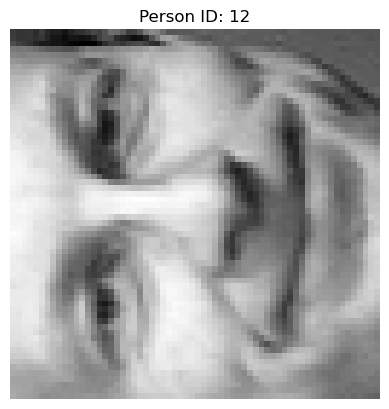

In [28]:
# Selecting an image
i = 123

plt.imshow(X[i], cmap=plt.cm.gray)
plt.axis("off")
plt.title(f"Person ID: {int(y[i, 0])}")
plt.show()

### Step 4: Training and testing sets

Setup training and testing sets . Use a 50/50 split for each class (5 training images and 5 test images per person). Print the dimension of each of the feature (image) matrices. Because this is a small dataset, we will also use the test set for validation.

In [29]:
# Creating the training and testing sets.

# strtify expects a 1D array, so I will flatten y from (400, 1) to (400,)
y_flat = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_flat,
    test_size=0.5,
    random_state=42,
    stratify=y_flat
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (200, 64, 64)
X_test shape: (200, 64, 64)
y_train shape: (200,)
y_test shape: (200,)


### Step 5: Vector conversion

Convert the vector of response variables to a matrix with 40 columns, with indicators for which person it is (one-hot encoded vectors). Print the dimensions of the new response vectors.

In [31]:
# Conversion

y_train_cat = to_categorical(y_train, num_classes=40)
y_test_cat = to_categorical(y_test, num_classes=40)

print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)

y_train_cat shape: (200, 40)
y_test_cat shape: (200, 40)


### Step 6: Reshape arrays

Reshape the image arrays so that they have 4 dimensions: (number of images, width of image, height of image, number of channels). For example, the array of training images should be (200, 64, 64, 1). Print the dimensions of the new image arrays.

In [33]:
# Reshape

X_train_cnn = X_train[..., np.newaxis]
X_test_cnn  = X_test[..., np.newaxis]

print("X_train_cnn shape:", X_train_cnn.shape)
print("X_test_cnn shape:", X_test_cnn.shape)

X_train_cnn shape: (200, 64, 64, 1)
X_test_cnn shape: (200, 64, 64, 1)


## Part 2: Model 1

### Step 7: Model 1's Architecture

Fit a convolutional neural network using the following architecture, and print the output from training.
*   1 convolutional layer with:
  * 16 filters (neurons)
  * a window size of 3
  * stride size of 1
  * ReLU activation function
  * padding so that the feature is the same size as the original image
*   1 max pooling layer with:
  * window size of 2
  * stride size of 2
  * no padding
*   1 fully connected output layer with:
  * 40 nodes for each face to predict
  * softmax activation function
*   For training, use the Adam optimizer, 20 epochs, a batch size of 10, and the categorical cross entropy loss function.

In [36]:
input_tensor = Input(shape=(64, 64, 1))

# Convolution Neural Network Model

x = Conv2D(filters=16, kernel_size=(3, 3), strides=(1,1),
           activation='relu', padding='same')(input_tensor)

x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)

x = Flatten()(x)

output = Dense(40, activation="softmax")(x)

model1 = Model(inputs=input_tensor, outputs=output)

model1.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │       655,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 655,560 (2.50 MB)

 Trainable params: 655,560 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compiling model1

model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
history1 = model1.fit(X_train_cnn, y_train_cat, epochs=20, batch_size=10, validation_data=(X_test_cnn, y_test_cat), verbose=1)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0300 - loss: 469.2748 - val_accuracy: 0.0250 - val_loss: 447.0848
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0300 - loss: 337.5323 - val_accuracy: 0.0250 - val_loss: 144.1835
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0450 - loss: 63.3251 - val_accuracy: 0.0950 - val_loss: 24.0352
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3050 - loss: 9.6211 - val_accuracy: 0.2800 - val_loss: 3.7979
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7300 - loss: 1.2145 - val_accuracy: 0.3550 - val_loss: 2.5000
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9500 - loss: 0.3157 - val_accuracy: 0.4950 - val_loss: 2.0466
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9900 - loss: 0.1033 - val_accuracy: 0.5200 - val_loss: 1.9671
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0366 - val_accuracy: 0.6000 -

### Step 8: Model 1's loss and accuracy

Print the loss and accuracy on the test set.

In [39]:
# Loss and Accuracy

test_loss, test_acc = model1.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.8134
Test Accuracy: 0.8000


### Step 9: Print image

Pick one of the images from the test set, and print the image.

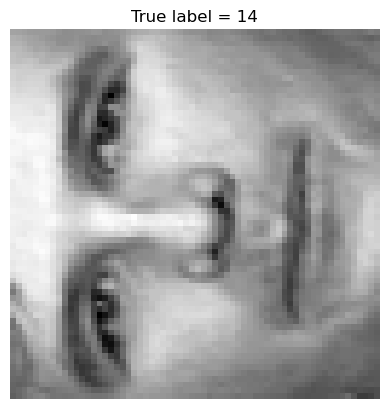

In [52]:
# An image

i = 135

plt.imshow(X_test[i], cmap=plt.cm.gray)
plt.axis("off")
plt.title(f"True label = {y_test[i]}")
plt.show()



### Step 10: Feature maps

For the image you selected in (9), print the images of the feature maps from both the convolutional and pooling layers.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Conv maps shape: (1, 64, 64, 16)
Pool maps shape: (1, 32, 32, 16)


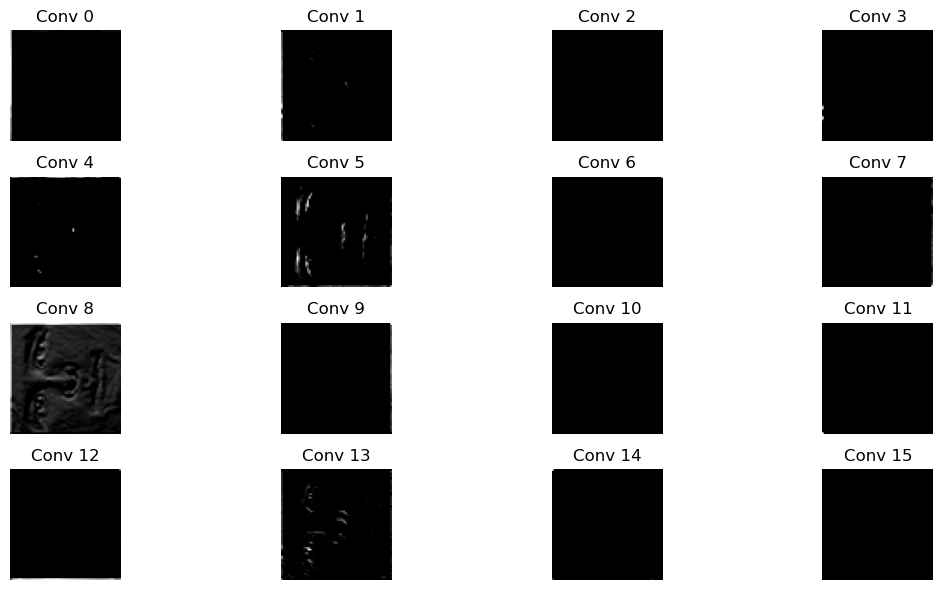

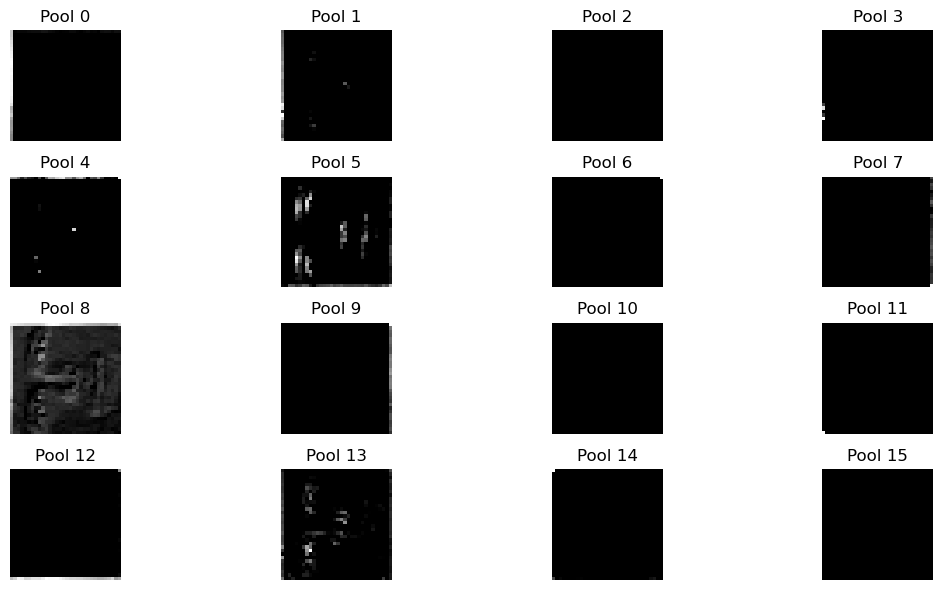

In [53]:
# Feature maps
conv_model = Model(
    inputs=model1.input,
    outputs=model1.layers[1].output
)
# For loop
pool_model = Model(
    inputs=model1.input,
    outputs=model1.layers[2].output
)

img = X_test_cnn[i:i+1]

conv_maps = conv_model.predict(img)
pool_maps = pool_model.predict(img)

print("Conv maps shape:", conv_maps.shape)
print("Pool maps shape:", pool_maps.shape)

plt.figure(figsize=(12, 6))
for j in range(conv_maps.shape[-1]):
    plt.subplot(4, 4, j + 1)
    plt.imshow(conv_maps[0, :, :, j], cmap='gray')
    plt.axis('off')
    plt.title(f'Conv {j}')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
for j in range(pool_maps.shape[-1]):
    plt.subplot(4, 4, j + 1)
    plt.imshow(pool_maps[0, :, :, j], cmap='gray')
    plt.axis('off')
    plt.title(f'Pool {j}')
plt.tight_layout()
plt.show()



## Part 3: Model 2




### Step 11: Model 2's Architecture

Fit the model from (7) again, but this time use a window size of 9 for the convolution layer.

In [54]:
# Change model1 so that it has a window size of 9.

input_tensor = Input(shape=(64, 64, 1))

# Convolution Neural Network Model

x = Conv2D(filters=16, kernel_size=(9, 9), strides=(1,1),
           activation='relu', padding='same')(input_tensor)

x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)

x = Flatten()(x)

output = Dense(40, activation="softmax")(x)

model2 = Model(inputs=input_tensor, outputs=output)

model2.summary()




Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 16)     │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │       655,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 656,712 (2.51 MB)

 Trainable params: 656,712 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Compiling model2

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_test_cnn, y_test_cat),
    epochs=20,
    batch_size=10,
    verbose=1
)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0200 - loss: 95.1158 - val_accuracy: 0.0500 - val_loss: 3.6704
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2450 - loss: 3.0445 - val_accuracy: 0.3350 - val_loss: 2.6332
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6800 - loss: 1.3103 - val_accuracy: 0.5950 - val_loss: 1.6692
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9450 - loss: 0.2328 - val_accuracy: 0.7250 - val_loss: 1.3218
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9950 - loss: 0.0243 - val_accuracy: 0.7400 - val_loss: 1.5600
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9950 - loss: 0.0090 - val_accuracy: 0.7800 - val_loss: 1.1000
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.7650 - val_loss: 1.4367
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3101e-04 - val_accuracy: 0.7600 - val

### Step 12: Model 2's loss and accuracy

Print the loss accuracy on the test set.

In [56]:
# Loss and Accuracy

test_loss2, test_acc2 = model2.evaluate(X_test_cnn, y_test_cat, verbose=0)

print(f"Model 2 Test Loss: {test_loss2:.4f}")
print(f"Model 2 Test Accuracy: {test_acc2:.4f}")



Model 2 Test Loss: 1.4682
Model 2 Test Accuracy: 0.7900


### Step 13: Feature Maps

Print the feature maps for the model in for the same image you used in (9) and (10).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Conv maps shape (Model 2): (1, 64, 64, 16)
Pool maps shape (Model 2): (1, 32, 32, 16)


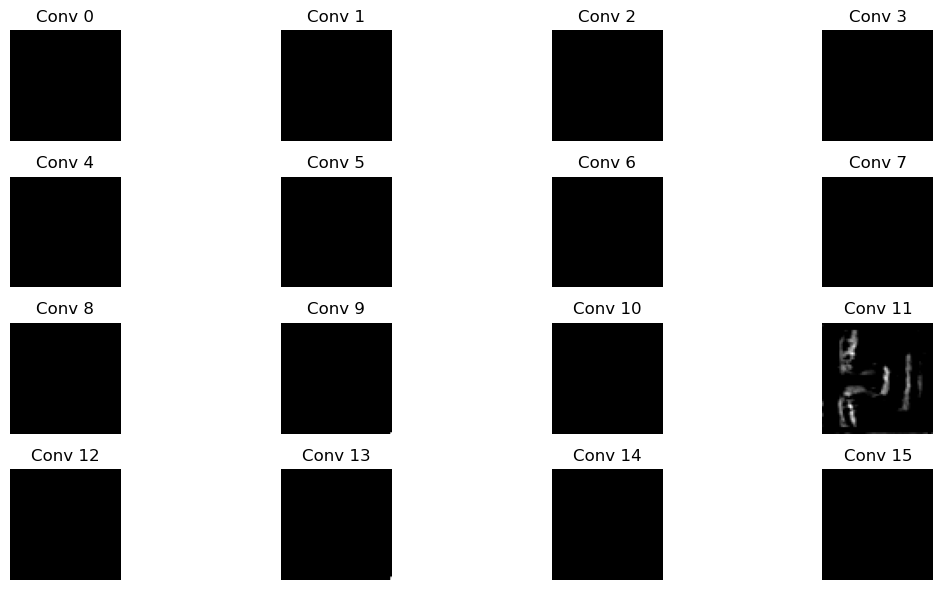

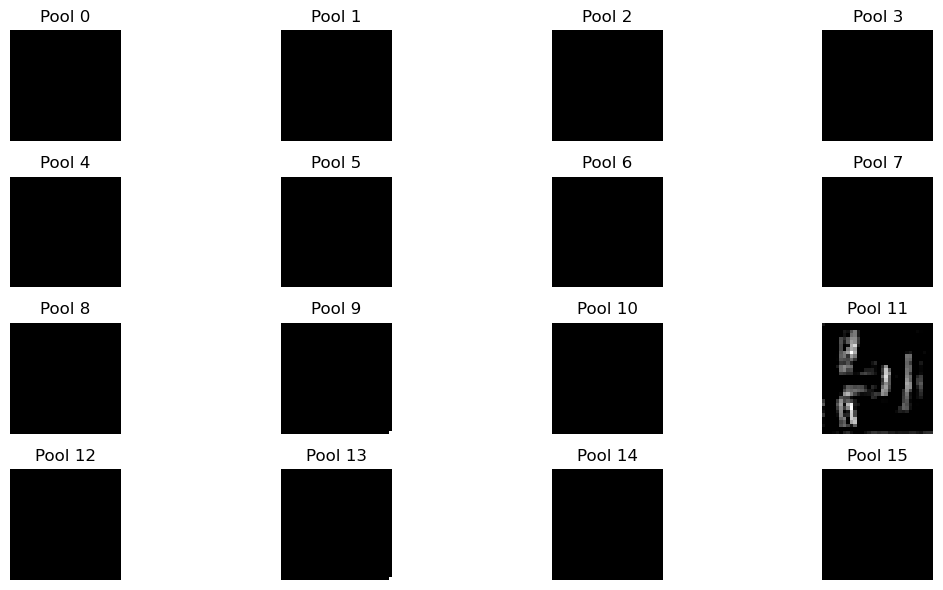

In [57]:
# Feature maps
conv_model2 = Model(
    inputs=model2.input,
    outputs=model2.layers[1].output
)

pool_model2 = Model(
    inputs=model2.input,
    outputs=model2.layers[2].output
)

img = X_test_cnn[i:i+1]

conv_maps2 = conv_model2.predict(img)
pool_maps2 = pool_model2.predict(img)

print("Conv maps shape (Model 2):", conv_maps2.shape)
print("Pool maps shape (Model 2):", pool_maps2.shape)

# For loop
plt.figure(figsize=(12, 6))
for j in range(conv_maps2.shape[-1]):
    plt.subplot(4, 4, j + 1)
    plt.imshow(conv_maps2[0, :, :, j], cmap='gray')
    plt.axis('off')
    plt.title(f'Conv {j}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for j in range(pool_maps2.shape[-1]):
    plt.subplot(4, 4, j + 1)
    plt.imshow(pool_maps2[0, :, :, j], cmap='gray')
    plt.axis('off')
    plt.title(f'Pool {j}')
plt.tight_layout()
plt.show()


## Part IV: Model comparison & model optimization


### Step 14: Model comparison

Comment on the differences in the features maps between this model and the previous one. Which network gave better predictions on the test set?

## Answer: Compared to model1, model2's feature maps are much more sparse and contain fewer visible activations. This is likely becuase the larger convolutional window for model2 produced smoother and more global features and overlooked fine localized details. Both models achieved nearly the same test accuracy, but model1 had more confident predictions and more informative feature maps, so it is the winner between the two.

### Step 15: Model 3- Optimized neural network

Optimize the neural network to improve the accuracy on the test set. You should try to get a better accuracy than both of the previous models.  Consider changing the following, then print the accuracy on the test set:
*   Number of convolutional and pooling layers
*   Number of filters in the convolutional layer
*   Window size
*   Number of fully connected layers and neurons
*   Regularization (L1/L2 penalty, dropout, early stopping)
*   Number of epochs and batch size

Call this model `model3`.

In [62]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
# Convolution Neural Network Model

input_tensor = Input(shape=(64, 64, 1))

x = Conv2D(32, (3, 3), strides=(1, 1), padding='same',
           activation='relu', kernel_regularizer=l2(1e-4))(input_tensor)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = Conv2D(64, (3, 3), strides=(1, 1), padding='same',
           activation='relu', kernel_regularizer=l2(1e-4))(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = Conv2D(128, (3, 3), strides=(1, 1), padding='same',
           activation='relu', kernel_regularizer=l2(1e-4))(x)

# Replacing the flatten with GlobalAveragePooling in order to msaaively reduce parameters
x = GlobalAveragePooling2D()(x)

# Small, dense ehad and dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.05)(x)

output = Dense(40, activation='softmax')(x)

model3 = Model(inputs=input_tensor, outputs=output)
model3.summary()



Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,344 (446.66 KB)

 Trainable params: 114,344 (446.66 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Compiling model3

model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True
)

history3 = model3.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_test_cnn, y_test_cat),
    epochs=60,
    batch_size=10,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0250 - loss: 6.4452 - val_accuracy: 0.0250 - val_loss: 3.7875
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0100 - loss: 3.7524 - val_accuracy: 0.0450 - val_loss: 3.7074
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0300 - loss: 3.7156 - val_accuracy: 0.0250 - val_loss: 3.7051
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0200 - loss: 3.7075 - val_accuracy: 0.0400 - val_loss: 3.6988
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0400 - loss: 3.7012 - val_accuracy: 0.0750 - val_loss: 3.6879
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0500 - loss: 3.6895 - val_accuracy: 0.0900 - val_loss: 3.6713
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0500 - loss: 3.6636 - val_accuracy: 0.0900 - val_loss: 3.6068
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0350 - loss: 3.5634 - val_accuracy: 0.0650 - v

### Step 16: Reflection on Model 3

Write a few sentences describing how you optimized the model in this part. What worked well?

## Answer: The model3 was excellent in performing and was improved from model2. Our key improvements include increased depth, better parameter efficiency, utilizing GlobalAveragePooling and L2 regularization. The loss decreased for train and validation in a smooth way, and there was no sudden overfitting. This indicates model3 is not simply memorizing the training data. Although model3 is a better example of a more modern CNN, and this network is more optimized than model1 or model2, it did not achieve a higher test accuracy than the other models. Model3's training and validation curves did show a better generalization ability as well as stabler learning, though. This might be due to the small size of the dataset, where simpler models can achieve a higher accuracy through memorization of the trainiing data, whereas a more regularized model might sacrifice accuracy for robust and stable qualities. 